## SHAP feature importance analysis
* [Combining categorical features](https://towardsdatascience.com/shap-for-categorical-features-7c63e6a554ea)
* [Different kinds of shap and tutorial](https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454)

In [9]:
import os
os.chdir("/home/jptalusan/mta_stationing_problem")

from copy import deepcopy
from src.config import *
from pprint import pprint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from pandas.core.common import SettingWithCopyWarning
from src import data_utils, triplevel_utils
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap

from pyspark.sql import SparkSession

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import swifter
import joblib
import shap

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_columns', None)
from pandas import MultiIndex, Int64Index
import xgboost as xgb
import importlib
importlib.reload(data_utils)

<module 'src.data_utils' from '/media/seconddrive/mta_stationing_problem/src/data_utils.py'>

In [4]:
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '40g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '20g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .getOrCreate()

22/09/07 22:12:01 WARN Utils: Your hostname, scope-vanderbilt resolves to a loopback address: 127.0.1.1; using 10.2.218.69 instead (on interface enp8s0)
22/09/07 22:12:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/07 22:12:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
# load the APC data from a prepared file
processed_triplevel = os.path.join('data', 'processed', 'triplevel_df.parquet')
if not os.path.exists(processed_triplevel):
    filepath = os.path.join(os.getcwd(), "data", "processed", "apc_weather_gtfs.parquet")
    apcdata = spark.read.load(filepath)
    apcdata.createOrReplaceTempView("apc")

    # filter subset
    query = f"""
                SELECT *
                FROM apc
            """
    apcdata=spark.sql(query)
    apcdata = data_utils.remove_nulls_from_apc(apcdata)
    apcdata.createOrReplaceTempView('apcdata')
    apcdata_per_trip = data_utils.get_apc_per_trip_sparkview(spark)
    df = apcdata_per_trip.toPandas()
    
    # Adding extra features
    # Holidays
    fp = os.path.join('data', 'others', 'US Holiday Dates (2004-2021).csv')
    holidays_df = pd.read_csv(fp)
    holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
    holidays_df['is_holiday'] = True
    df = df.merge(holidays_df[['Date', 'is_holiday']], left_on='transit_date', right_on='Date', how='left')
    df['is_holiday'] = df['is_holiday'].fillna(False)
    df = df.drop(columns=['Date'])
    
    # School breaks
    fp = os.path.join('data', 'others', 'School Breaks (2019-2022).pkl')
    school_break_df = pd.read_pickle(fp)
    school_break_df['is_school_break'] = True
    df = df.merge(school_break_df[['Date', 'is_school_break']], left_on='transit_date', right_on='Date', how='left')
    df['is_school_break'] = df['is_school_break'].fillna(False)
    df = df.drop(columns=['Date'])

    # Traffic
    fp = os.path.join('data', 'traffic', 'triplevel_speed.pickle')
    speed_df = pd.read_pickle(fp)
    speed_df = speed_df[['transit_date', 'trip_id', 'route_id_direction', 'traffic_speed']]
    df = df.merge(speed_df, how='left', 
                  left_on =['transit_date', 'trip_id', 'route_id_direction'], 
                  right_on=['transit_date', 'trip_id', 'route_id_direction'])
    df = df[~df['traffic_speed'].isna()]
    df.to_parquet(processed_triplevel, engine='auto', compression='gzip')
else:
    df = pd.read_parquet(processed_triplevel, engine='auto')
    df = df.dropna()
    # Removing time_window in case a different one will be used
df = df.drop(['time_window', 'load'], axis=1)
df = df.reset_index(drop=True)

In [11]:
RANDOM_SEED = 100
WINDOW = 30
PAST_TRIPS = 5
TARGET = 'y_reg100'

In [19]:
cat_features = ['route_id_direction', 'is_holiday', 'dayofweek', 'is_school_break', 'time_window']
ord_features = ['year', 'month', 'hour', 'day']
num_features = ['temperature', 'humidity', 'precipitation_intensity', 'avg_sched_headway', 'traffic_speed',
                'load_pct_change', 'act_headway_pct_change', 'avg_past_act_headway', 'avg_past_trips_loads']

tdf = triplevel_utils.generate_new_day_ahead_features(df, time_window=WINDOW, past_trips=PAST_TRIPS, target=TARGET)
tdf = tdf.groupby(['transit_date', 'route_id_direction', 'time_window']).agg({"year":"first", 
                                                                              "month":"first",
                                                                              "day": "first",
                                                                              "hour":"first",
                                                                              "is_holiday": "first",
                                                                              "is_school_break": "first",
                                                                              "dayofweek":"first",
                                                                              "temperature":"mean", 
                                                                              "humidity":"mean",
                                                                              "precipitation_intensity": "mean",
                                                                              "traffic_speed":"mean",
                                                                              "scheduled_headway": "max",
                                                                              "load_pct_change": "max",
                                                                              "act_headway_pct_change": "max",
                                                                              "avg_past_act_headway": "max",
                                                                              "avg_past_trips_loads": "max",
                                                                              TARGET: "max" })
tdf = tdf.reset_index(level=[0,1,2])
print("ohe_encoder is for the following column order:", cat_features)
rf_df, ix_map, ohe_encoder, percentiles = triplevel_utils.prepare_df_for_training(tdf, cat_features, ord_features, target=TARGET)
target_load = rf_df[[TARGET]]
drop_cols = ['time_window', 'route_id', 'route_direction_name', 'block_abbr', 'y_reg100', 'y_reg095', 'transit_date', 'is_holiday', 'route_id_direction', 'actual_headways', 'trip_id', 'arrival_time']
drop_cols = [col for col in drop_cols if col in rf_df.columns]
rf_df = rf_df.drop(drop_cols, axis=1)
y = rf_df.pop('y_class')
X = rf_df

ohe_encoder is for the following column order: ['route_id_direction', 'is_holiday', 'dayofweek', 'is_school_break', 'time_window']


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=RANDOM_SEED)

In [25]:
X_train.shape, X_test.shape

((255634, 137), (109558, 137))

In [26]:
objective = 'multi:softmax'
model = xgb.XGBClassifier(use_label_encoder=False, objective=objective, eval_metric='mlogloss', num_class=3)
model.fit(X_train, y_train, verbose=1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=32,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              use_label_encoder=False, ...)

In [27]:
X_sampled = X_test.sample(500, random_state=500)
X_sampled

temperature  humidity  precipitation_intensity  traffic_speed  \
182649    64.709000  0.440000                   0.0000      18.049519   
9669      46.444000  0.809000                   0.0056      16.208095   
214459    90.962143  0.409912                   0.0000      20.648971   
290064    76.153000  0.517000                   0.0000      16.884067   
247130    91.274091  0.575152                   0.0000      20.052560   
...             ...       ...                      ...            ...   
202009    86.430000  0.417600                   0.0000      20.525472   
108017    62.013000  0.910000                   0.0000      19.868512   
2236      48.161782  0.559261                   0.0000      18.472205   
301411    50.038472  0.755059                   0.0000      22.098808   
521       47.105000  0.568000                   0.0002      18.052031   

        scheduled_headway  load_pct_change  act_headway_pct_change  \
182649        9600.000000        -0.454545               -0.504219   
9669          1200.000000        -0.468750                0.891768   
214459        1800.000000         2.000000                0.341173   
290064        1802.968750         5.500000                0.633944   
247130         600.000000         0.038462               -0.222607   
...                   ...              ...                     ...   
202009        1680.000000         0.222222               -0.354169   
108017        1800.000000        -0.775000                0.345937   
2236          2700.000000         5.333333                1.188584   
301411        5235.882353         1.000000                1.744506   
521           2400.000000         0.642857                0.202989   

        avg_past_act_headway  avg_past_trips_loads  year_ix  month_ix  \
182649           4859.976190                  19.0        1         3   
9669             4605.333333                  23.0        0         0   
214459           4904.565217                  20.0        1         5   
290064           2589.181818                  16.0        1         9   
247130           3676.428571                  26.0        1         7   
...                      ...                   ...      ...       ...   
202009           4732.758621                  44.0        1         4   
108017           3599.250000                  40.0        0         9   
2236             2798.486486                  13.0        0         0   
301411           5502.837838                  13.0        1        10   
521              2485.458333                  23.0        0         0   

        hour_ix  day_ix  route_id_direction_14_FROM DOWNTOWN  \
182649       12      17                                  0.0   
9669         15      28                                  0.0   
214459       11      13                                  0.0   
290064       12      19                                  0.0   
247130       13       8                                  0.0   
...         ...     ...                                  ...   
202009       13      21                                  0.0   
108017       18      26                                  0.0   
2236         10       5                                  0.0   
301411       19       6                                  0.0   
521           3       1                                  0.0   

        route_id_direction_14_TO DOWNTOWN  \
182649                                0.0   
9669                                  0.0   
214459                                0.0   
290064                                0.0   
247130                                0.0   
...                                   ...   
202009                                0.0   
108017                                0.0   
2236                                  0.0   
301411                                0.0   
521                                   0.0   

        route_id_direction_17_FROM DOWNTOWN  \
182649                                  0.0   
9669     

In [193]:
non_ohe_count = 13

# get shap values
from shap import TreeExplainer, Explanation
from shap.plots import waterfall
X_sampled = X_test.sample(500, random_state=500)
explainer = shap.Explainer(model.predict, X_sampled)
sv = explainer(X_sampled)

# combining the one hot encoded values
new_features = X_sampled.columns[:non_ohe_count].tolist()
new_features.extend(['route_id_dir', 'holiday', 'dow', 'school_break', 'time_window'])
idx = 1
non_ohe_sv      = sv.values[:,:non_ohe_count,idx]
route_id_dir_sv = sv.values[:,non_ohe_count:74+non_ohe_count,idx].sum(axis=1)
is_holiday_sv   = sv.values[:,74+non_ohe_count:74+non_ohe_count+2,idx].sum(axis=1)
dayofweek_sv    = sv.values[:,74+non_ohe_count+2:74+non_ohe_count+2+7,idx].sum(axis=1)
school_break_sv = sv.values[:,74+non_ohe_count+2+7:74+non_ohe_count+2+7+2,idx].sum(axis=1)
time_window_sv  = sv.values[:,74+non_ohe_count+2+7+2:,idx].sum(axis=1)

non_ohe_sv = np.append(non_ohe_sv, route_id_dir_sv.reshape(-1, 1), 1)
non_ohe_sv = np.append(non_ohe_sv, is_holiday_sv.reshape(-1, 1), 1)
non_ohe_sv = np.append(non_ohe_sv, dayofweek_sv.reshape(-1, 1), 1)
non_ohe_sv = np.append(non_ohe_sv, time_window_sv.reshape(-1, 1), 1)

Permutation explainer: 501it [00:18, 12.23it/s]                         


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
print(new_features, len(new_features))

['temperature', 'humidity', 'precipitation_intensity', 'traffic_speed', 'scheduled_headway', 'load_pct_change', 'act_headway_pct_change', 'avg_past_act_headway', 'avg_past_trips_loads', 'year_ix', 'month_ix', 'hour_ix', 'day_ix', 'route_id_dir', 'holiday', 'dow', 'time_window'] 17


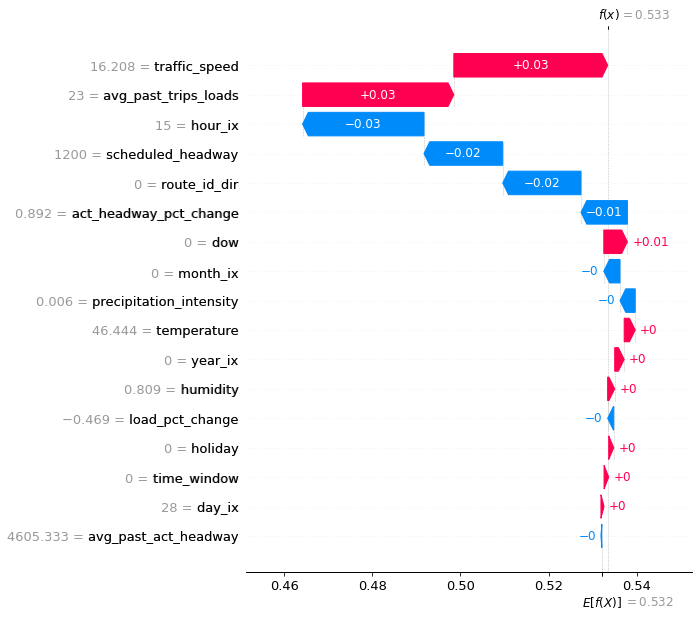

In [ ]:
exp = Explanation(non_ohe_sv, 
                  sv.base_values[:,idx], 
                  data=X_sampled.values, 
                  feature_names=new_features)
waterfall(exp[idx], max_display=17)

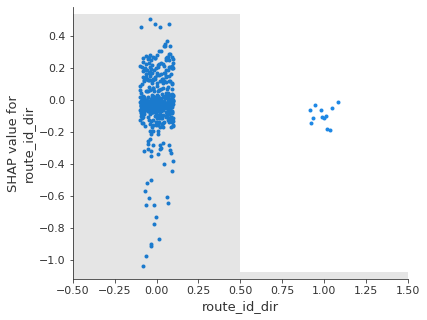

In [42]:
shap.plots.scatter(exp[:, non_ohe_count])
shap.initjs()

In [46]:
shap.plots.force(exp[488], features=new_features)
shap.initjs()

shap.force_plot(sv.expected_value, matplotlib=True, show=False)
plt.savefig('force_plot.png')

AttributeError: 'Explanation' object has no attribute 'expected_value'

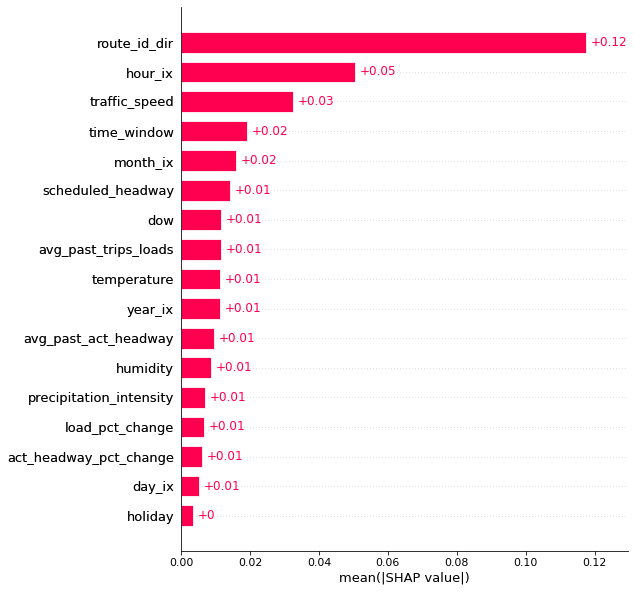

In [60]:
shap.plots.bar(exp, max_display=18)

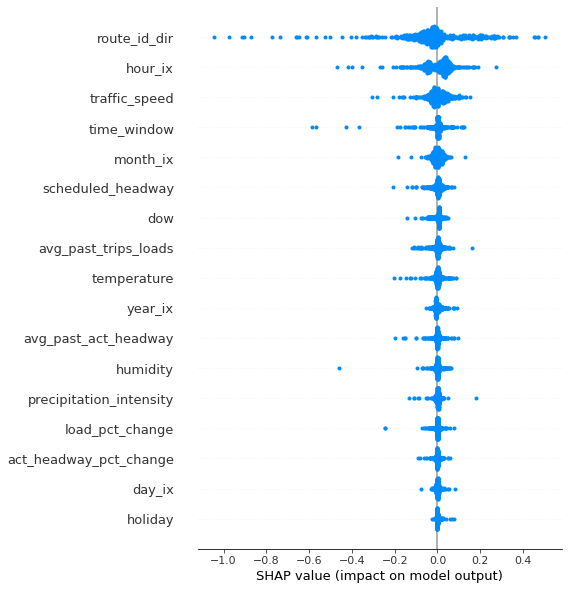

In [90]:
shap.summary_plot(exp, features=new_features)

70

In [219]:
# Fits the explainer
X_sampled = X_test.sample(2000, random_state=500)
explainer = shap.Explainer(model.predict, X_sampled)
# Calculates the SHAP values - It takes some time
sv = explainer(X_sampled)

new_features = X_sampled.columns[:non_ohe_count].tolist()
new_features.extend(['route_id_dir', 'holiday', 'dow', 'school_break', 'time_window'])

# sanity checks:
route_id_dir_count = len(X_sampled.filter(regex='route_id_direction').columns)

print(X_sampled.columns[:non_ohe_count].tolist())
non_ohe_sv      = sv.values[:,:non_ohe_count]

print(X_sampled.columns[non_ohe_count:non_ohe_count+route_id_dir_count].tolist())
route_id_dir_sv = sv.values[:,non_ohe_count:non_ohe_count+route_id_dir_count].sum(axis=1)

print(X_sampled.columns[route_id_dir_count+non_ohe_count:route_id_dir_count+non_ohe_count+2].tolist())
is_holiday_sv   = sv.values[:,route_id_dir_count+non_ohe_count:route_id_dir_count+non_ohe_count+2].sum(axis=1)

print(X_sampled.columns[route_id_dir_count+non_ohe_count+2:route_id_dir_count+non_ohe_count+2+7].tolist())
dayofweek_sv    = sv.values[:,route_id_dir_count+non_ohe_count+2:route_id_dir_count+non_ohe_count+2+7].sum(axis=1)

print(X_sampled.columns[route_id_dir_count+non_ohe_count+2+7:route_id_dir_count+non_ohe_count+2+7+2].tolist())
school_break_sv = sv.values[:,route_id_dir_count+non_ohe_count+2+7:route_id_dir_count+non_ohe_count+2+7+2].sum(axis=1)

print(X_sampled.columns[route_id_dir_count+non_ohe_count+2+7+2:].tolist())
time_window_sv  = sv.values[:,route_id_dir_count+non_ohe_count+2+7+2:].sum(axis=1)

non_ohe_sv = np.append(non_ohe_sv, route_id_dir_sv.reshape(-1, 1), 1)
non_ohe_sv = np.append(non_ohe_sv, is_holiday_sv.reshape(-1, 1), 1)
non_ohe_sv = np.append(non_ohe_sv, dayofweek_sv.reshape(-1, 1), 1)
non_ohe_sv = np.append(non_ohe_sv, school_break_sv.reshape(-1, 1), 1)
non_ohe_sv = np.append(non_ohe_sv, time_window_sv.reshape(-1, 1), 1)

inverse_sampled = deepcopy(X_sampled)
inverse_sampled[cat_features] = ohe_encoder.inverse_transform(X_sampled.filter(regex='route_id_direction_|is_holiday_|dayofweek_|is_school_|time_window_'))
inverse_sampled = inverse_sampled.drop(columns=X_sampled.filter(regex='route_id_direction_|is_holiday_|dayofweek_|is_school_|time_window_').columns, axis=1)
inverse_sampled = inverse_sampled.rename({'route_id_direction':'route_id_dir', 'is_holiday':'holiday', 'dayofweek':'dow'}, axis=1)

exp = Explanation(non_ohe_sv, 
                  sv.base_values[:18], 
                  data=inverse_sampled.values, 
                  feature_names=new_features)

Permutation explainer: 2001it [01:16, 22.70it/s]                          

['temperature', 'humidity', 'precipitation_intensity', 'traffic_speed', 'scheduled_headway', 'load_pct_change', 'act_headway_pct_change', 'avg_past_act_headway', 'avg_past_trips_loads', 'year_ix', 'month_ix', 'hour_ix', 'day_ix']
['route_id_direction_14_FROM DOWNTOWN', 'route_id_direction_14_TO DOWNTOWN', 'route_id_direction_17_FROM DOWNTOWN', 'route_id_direction_17_TO DOWNTOWN', 'route_id_direction_18_FROM DOWNTOWN', 'route_id_direction_18_TO DOWNTOWN', 'route_id_direction_19_FROM DOWNTOWN', 'route_id_direction_19_TO DOWNTOWN', 'route_id_direction_21_NORTHBOUND', 'route_id_direction_21_SOUTHBOUND', 'route_id_direction_22_FROM DOWNTOWN', 'route_id_direction_22_TO DOWNTOWN', 'route_id_direction_23_FROM DOWNTOWN', 'route_id_direction_23_TO DOWNTOWN', 'route_id_direction_24_FROM DOWNTOWN', 'route_id_direction_24_TO DOWNTOWN', 'route_id_direction_25_NORTHBOUND', 'route_id_direction_25_SOUTHBOUND', 'route_id_direction_28_FROM DOWNTOWN', 'route_id_direction_28_TO DOWNTOWN', 'route_id_directi

In [220]:
# X_sampled = X_test.sample(500, random_state=500)
# inverse_sampled = deepcopy(X_sampled)
# inverse_sampled[cat_features] = ohe_encoder.inverse_transform(X_sampled.filter(regex='route_id_direction_|is_holiday_|dayofweek_|is_school_|time_window_'))
# inverse_sampled = inverse_sampled.drop(columns=X_sampled.filter(regex='route_id_direction_|is_holiday_|dayofweek_|is_school_|time_window_').columns, axis=1)
# inverse_sampled = inverse_sampled.rename({'route_id_direction':'route_id_dir', 'is_holiday':'holiday', 'dayofweek':'dow'}, axis=1)
# inverse_sampled

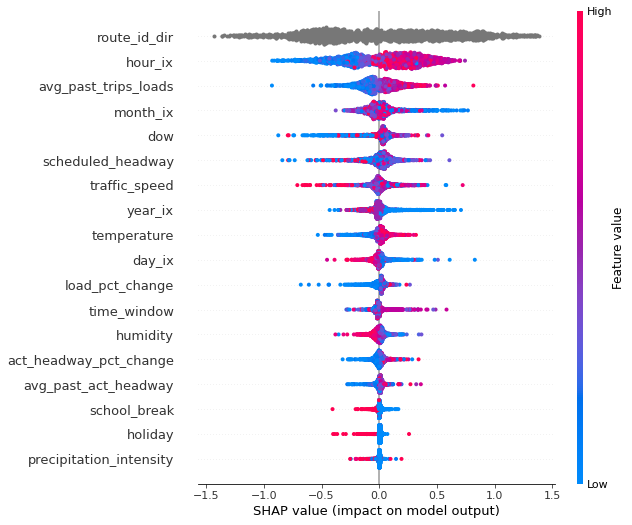

In [221]:
shap.plots.beeswarm(exp, max_display=19)

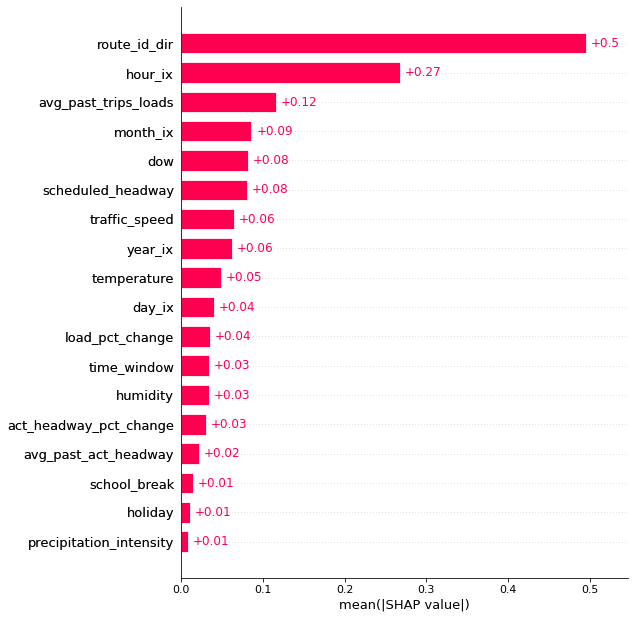

In [222]:
shap.plots.bar(exp, max_display=19)

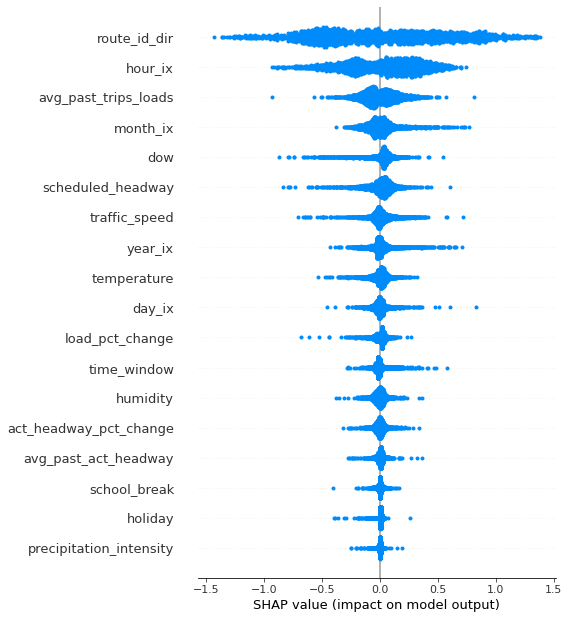

In [223]:
shap.summary_plot(exp, features=new_features)

In [224]:
# shap.plots.force(exp, features=new_features, show=False)
# shap.initjs()

In [225]:
shap.force_plot(exp, matplotlib=False, show=False)
# plt.savefig('force_plot.png')

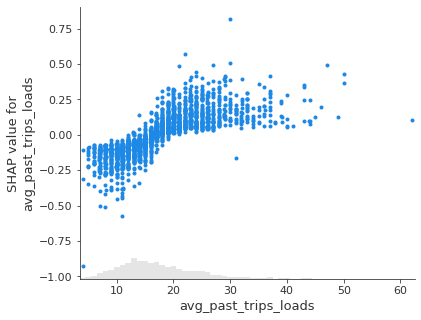

In [231]:
shap.plots.scatter(exp[:, 8])
shap.initjs()

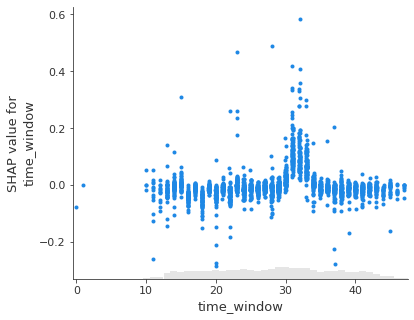

In [227]:
shap.plots.scatter(exp[:, -1])
shap.initjs()

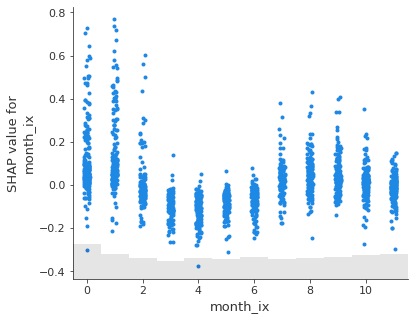

In [228]:
shap.plots.scatter(exp[:, 10])
shap.initjs()

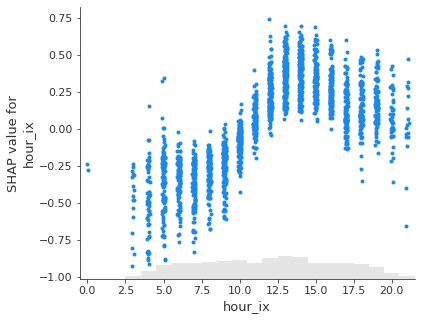

In [229]:
shap.plots.scatter(exp[:, 11])
shap.initjs()